In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 30
validation_split = 0.2

# Set random seed for reproducibility
torch.manual_seed(12)

# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize(224),  # Resize to match input size for VGG and ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 Dataset
full_train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

# Create training-validation split with fixed seed for consistency
train_size = int((1 - validation_split) * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Test dataset and loader
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



Files already downloaded and verified
Files already downloaded and verified


In [11]:
# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

# Training function with validation, learning rate scheduling, and accuracy calculation
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name):
    model.train()
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    # Set up the learning rate scheduler to decrease LR every 10 epochs by a factor of 0.1
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accumulate training loss
            running_train_loss += loss.item() * images.size(0)
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Accumulate validation loss
                running_val_loss += loss.item() * images.size(0)
                
                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        # Print results for this epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
        
        # Step the learning rate scheduler every epoch
        scheduler.step()
    
    # Save the model after training
    torch.save(model.state_dict(), f"{model_name}_cifar10.pth")
    print(f"Model {model_name} saved!")
    
    # Return losses and accuracies for plotting
    return train_losses, val_losses, train_accuracies, val_accuracies


In [3]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

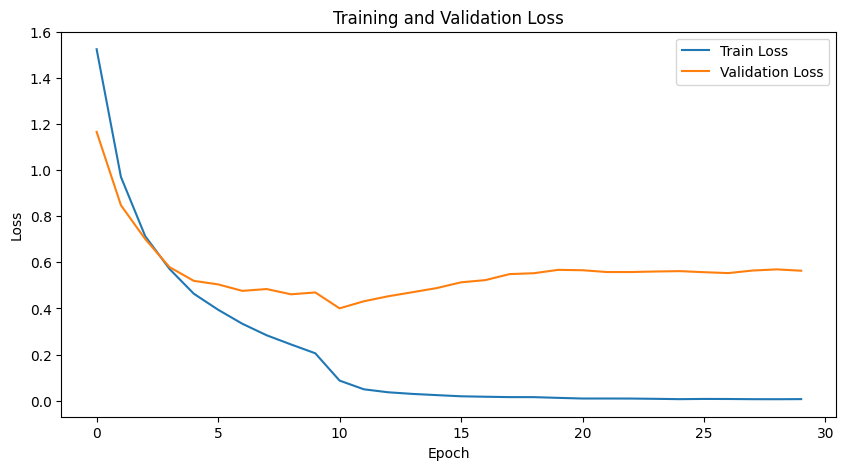

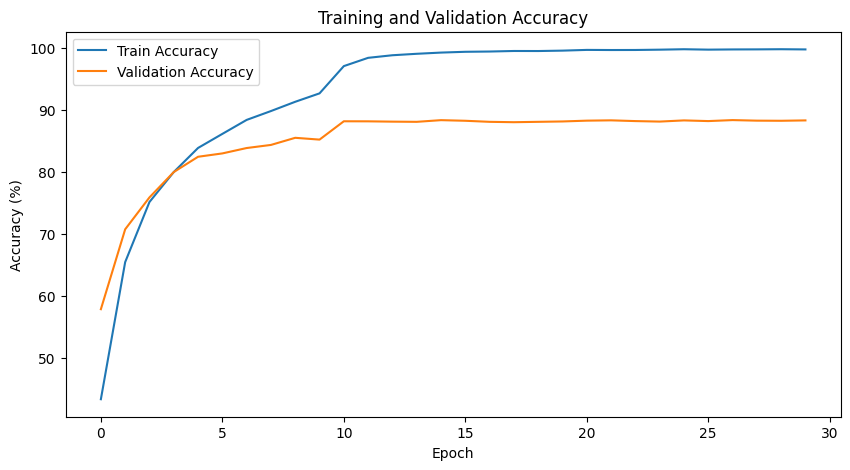

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plotting the training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


In [ ]:
# Evaluate the model on the test set
test_accuracy = evaluate_model(model, test_loader)

In [ ]:
# Re-initialize the EfficientNet-B0 model to reset weights for training with SGD
model_sgd = get_efficientnet_b0_model()

# Define the SGD optimizer with momentum
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=learning_rate, momentum=0.9)

# Train the model with SGD optimizer
train_losses_sgd, val_losses_sgd, train_accuracies_sgd, val_accuracies_sgd = train_model(
    model_sgd, train_loader, val_loader, criterion, optimizer_sgd, num_epochs, "EfficientNet-B0_SGD"
)


Epoch [1/30], Train Loss: 1.8767, Val Loss: 1.5383, Train Acc: 29.24%, Val Acc: 44.02%
Epoch [2/30], Train Loss: 1.4026, Val Loss: 1.2520, Train Acc: 48.62%, Val Acc: 56.07%
Epoch [3/30], Train Loss: 1.1749, Val Loss: 1.0589, Train Acc: 57.46%, Val Acc: 61.48%
Epoch [4/30], Train Loss: 1.0085, Val Loss: 0.9215, Train Acc: 63.82%, Val Acc: 67.22%
Epoch [5/30], Train Loss: 0.8875, Val Loss: 0.8180, Train Acc: 68.42%, Val Acc: 71.04%
Epoch [6/30], Train Loss: 0.7910, Val Loss: 0.7465, Train Acc: 71.96%, Val Acc: 73.84%
Epoch [7/30], Train Loss: 0.7078, Val Loss: 0.6923, Train Acc: 75.30%, Val Acc: 75.74%
Epoch [8/30], Train Loss: 0.6429, Val Loss: 0.7084, Train Acc: 77.43%, Val Acc: 75.42%
Epoch [9/30], Train Loss: 0.5826, Val Loss: 0.6630, Train Acc: 79.58%, Val Acc: 77.57%
Epoch [10/30], Train Loss: 0.5283, Val Loss: 0.6688, Train Acc: 81.67%, Val Acc: 77.69%
Epoch [11/30], Train Loss: 0.4198, Val Loss: 0.5848, Train Acc: 85.63%, Val Acc: 80.34%
Epoch [12/30], Train Loss: 0.3960, Val Lo

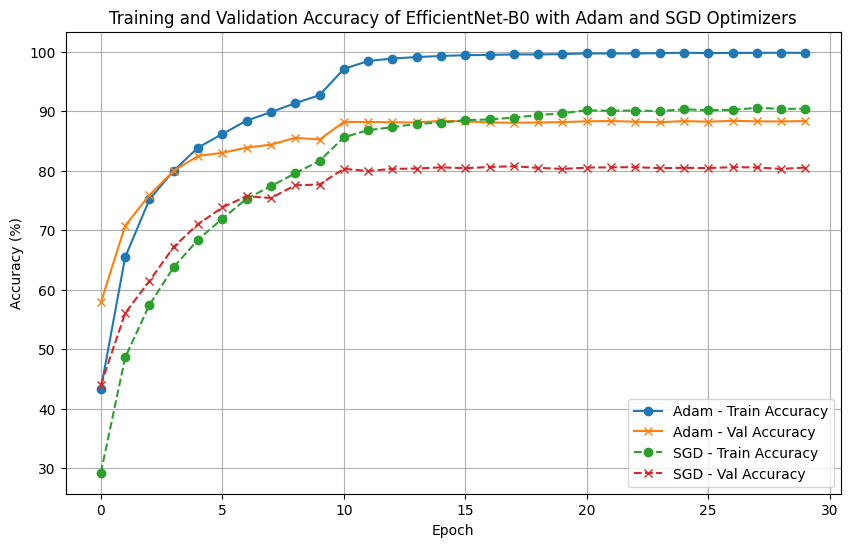

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy for both Adam and SGD optimizers
plt.figure(figsize=(10, 6))

# Plot for Adam optimizer
plt.plot(train_accuracies, label="Adam - Train Accuracy", linestyle="-", marker="o")
plt.plot(val_accuracies, label="Adam - Val Accuracy", linestyle="-", marker="x")

# Plot for SGD optimizer
plt.plot(train_accuracies_sgd, label="SGD - Train Accuracy", linestyle="--", marker="o")
plt.plot(val_accuracies_sgd, label="SGD - Val Accuracy", linestyle="--", marker="x")

# Labels and Title
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy of EfficientNet-B0 with Adam and SGD Optimizers")
plt.legend()
plt.grid(True)
plt.show()


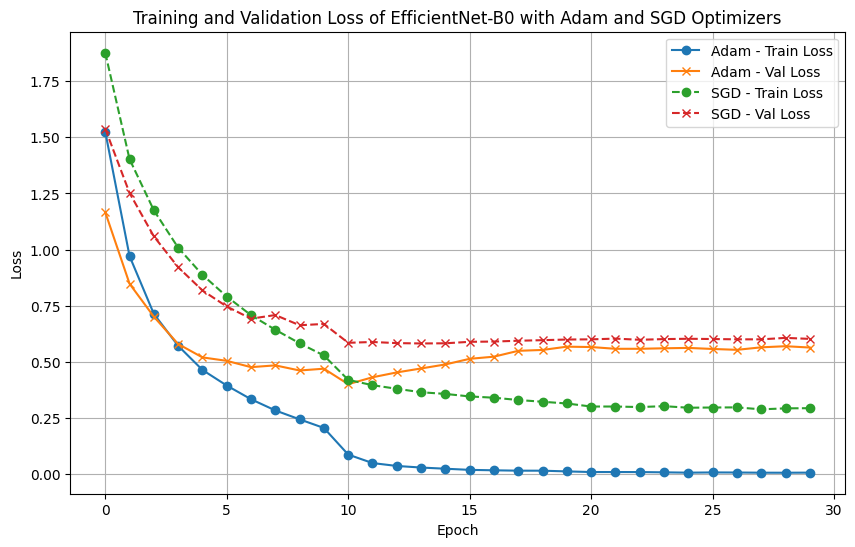

In [ ]:
# Plot Training and Validation Loss for both Adam and SGD optimizers
plt.figure(figsize=(10, 6))

# Plot for Adam optimizer
plt.plot(train_losses, label="Adam - Train Loss", linestyle="-", marker="o")
plt.plot(val_losses, label="Adam - Val Loss", linestyle="-", marker="x")

# Plot for SGD optimizer
plt.plot(train_losses_sgd, label="SGD - Train Loss", linestyle="--", marker="o")
plt.plot(val_losses_sgd, label="SGD - Val Loss", linestyle="--", marker="x")

# Labels and Title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss of EfficientNet-B0 with Adam and SGD Optimizers")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Load the model trained with SGD (assuming the model was saved after training)
model_sgd.load_state_dict(torch.load("EfficientNet-B0_SGD_cifar10.pth"))

# Evaluate the model on the test set
test_accuracy_sgd = evaluate_model(model_sgd, test_loader)
print(f"EfficientNet-B0 Test Accuracy with SGD Optimizer: {test_accuracy_sgd:.2f}%")


/tmp/ipykernel_154759/1573304741.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_sgd.load_state_dict(torch.load("EfficientNet-B0_SGD_cifar10.pth"))


EfficientNet-B0 Test Accuracy with SGD Optimizer: 81.04%


### Dropout Ablation Study

In [2]:
# Define EfficientNet-B0 with customizable dropout rate
def get_efficientnet_b0_model(dropout_rate=0.2):
    # Initialize EfficientNet-B0 without pretrained weights
    efficientnet_b0 = models.efficientnet_b0(pretrained=False)
    
    # Modify the final classifier layer to include dropout and adjust for CIFAR-10 (10 classes)
    num_features = efficientnet_b0.classifier[1].in_features
    efficientnet_b0.classifier = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(num_features, 10)
    )
    
    return efficientnet_b0.to(device)

In [1]:
# Define baseline accuracy and losses (Dropout = 0)
baseline_accuracy = 88.36  # Replace with actual baseline test accuracy
baseline_train_accuracies = [
    43.34, 65.48, 75.19, 80.02, 83.91, 86.18, 88.44, 89.87, 91.37, 92.72, 
    97.12, 98.46, 98.88, 99.11, 99.31, 99.44, 99.63, 99.57, 99.56, 99.62, 
    99.74, 99.78, 99.73, 99.78, 99.78, 99.82, 99.82, 99.83, 99.82, 99.82
]
baseline_val_accuracies = [
    57.88, 70.78, 75.93, 80.02, 82.49, 83.03, 83.91, 84.40, 85.56, 85.26,
    88.22, 88.28, 88.16, 88.30, 88.40, 88.30, 88.32, 88.07, 88.13, 88.18,
    88.36, 88.32, 88.28, 88.18, 88.18, 88.18, 88.30, 88.32, 88.32, 88.36
]
baseline_train_losses = [
    1.5250, 0.9709, 0.7137, 0.5715, 0.4639, 0.3945, 0.3335, 0.2836, 0.2439, 0.2055, 
    0.0870, 0.0492, 0.0363, 0.0292, 0.0240, 0.0189, 0.0169, 0.0153, 0.0152, 0.0120, 
    0.0092, 0.0093, 0.0091, 0.0079, 0.0073, 0.0065, 0.0074, 0.0061, 0.0063, 0.0066
]
baseline_val_losses = [
    1.1664, 0.8479, 0.7012, 0.5795, 0.5198, 0.5045, 0.4764, 0.4843, 0.4615, 0.4695,
    0.4005, 0.4313, 0.4529, 0.4705, 0.4884, 0.5134, 0.5231, 0.5491, 0.5530, 0.5675,
    0.5659, 0.5581, 0.5581, 0.5604, 0.5574, 0.5581, 0.5636, 0.5646, 0.5638, 0.5638
]

# Store baseline metrics in results dictionary
results = {
    0.0: {
        "test_accuracy": baseline_accuracy,
        "train_accuracies": baseline_train_accuracies,
        "val_accuracies": baseline_val_accuracies,
        "train_losses": baseline_train_losses,
        "val_losses": baseline_val_losses,
    }
}

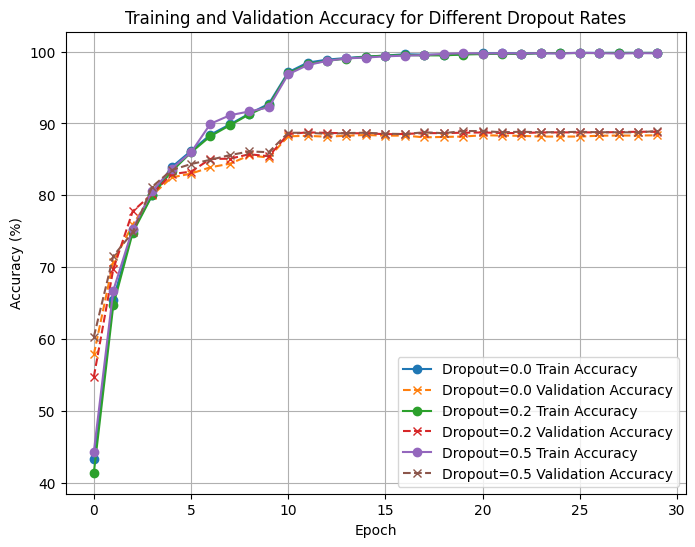

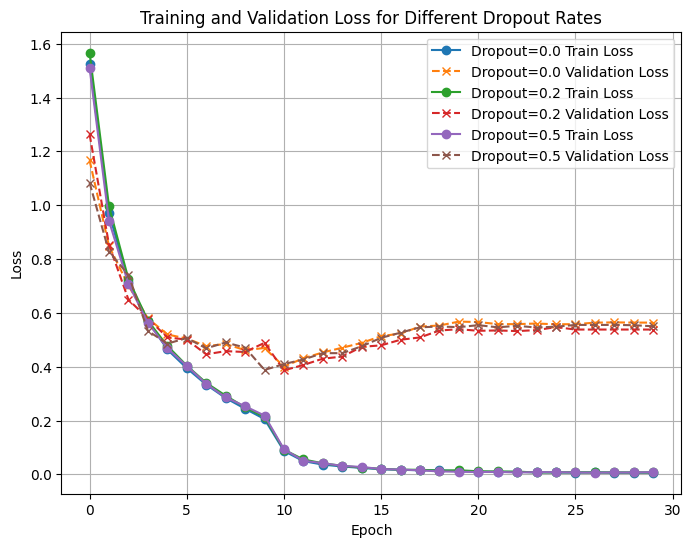

In [ ]:
import matplotlib.pyplot as plt

# Define the dropout rates and their corresponding results
dropout_rates = [0.0, 0.2, 0.5]
results = {
    0.0: {
        "train_accuracies": [
            43.34, 65.48, 75.19, 80.02, 83.91, 86.18, 88.44, 89.87, 91.37, 92.72, 
            97.12, 98.46, 98.88, 99.11, 99.31, 99.44, 99.63, 99.57, 99.56, 99.62, 
            99.74, 99.78, 99.73, 99.78, 99.78, 99.82, 99.82, 99.83, 99.82, 99.82
        ],
        "val_accuracies": [
            57.88, 70.78, 75.93, 80.02, 82.49, 83.03, 83.91, 84.40, 85.56, 85.26,
            88.22, 88.28, 88.16, 88.30, 88.40, 88.30, 88.32, 88.07, 88.13, 88.18,
            88.36, 88.32, 88.28, 88.18, 88.18, 88.18, 88.30, 88.32, 88.32, 88.36
        ],
        "train_losses": [
            1.5250, 0.9709, 0.7137, 0.5715, 0.4639, 0.3945, 0.3335, 0.2836, 0.2439, 0.2055, 
            0.0870, 0.0492, 0.0363, 0.0292, 0.0240, 0.0189, 0.0169, 0.0153, 0.0152, 0.0120, 
            0.0092, 0.0093, 0.0091, 0.0079, 0.0073, 0.0065, 0.0074, 0.0061, 0.0063, 0.0066
        ],
        "val_losses": [
            1.1664, 0.8479, 0.7012, 0.5795, 0.5198, 0.5045, 0.4764, 0.4843, 0.4615, 0.4695,
            0.4005, 0.4313, 0.4529, 0.4705, 0.4884, 0.5134, 0.5231, 0.5491, 0.5530, 0.5675,
            0.5659, 0.5581, 0.5581, 0.5604, 0.5574, 0.5581, 0.5636, 0.5646, 0.5638, 0.5638
        ]
    },
    0.2: {
        "train_accuracies": [
            41.43, 64.70, 74.81, 80.00, 83.33, 85.97, 88.24, 89.75, 91.28, 92.52, 
            96.97, 98.27, 98.71, 99.03, 99.28, 99.44, 99.51, 99.47, 99.47, 99.59, 
            99.65, 99.70, 99.65, 99.78, 99.80, 99.78, 99.80, 99.80, 99.81, 99.81
        ],
        "val_accuracies": [
            54.77, 69.74, 77.79, 80.20, 82.96, 83.30, 85.07, 85.10, 85.72, 85.44,
            88.52, 88.77, 88.69, 88.64, 88.64, 88.51, 88.54, 88.66, 88.66, 88.72,
            88.75, 88.67, 88.67, 88.76, 88.76, 88.76, 88.76, 88.80, 88.85, 88.85
        ],
        "train_losses": [
            1.5664, 0.9956, 0.7258, 0.5707, 0.4775, 0.4041, 0.3400, 0.2924, 0.2491, 0.2129,
            0.0918, 0.0554, 0.0411, 0.0315, 0.0251, 0.0208, 0.0171, 0.0172, 0.0138, 0.0152,
            0.0115, 0.0107, 0.0101, 0.0071, 0.0073, 0.0079, 0.0071, 0.0074, 0.0070, 0.0070
        ],
        "val_losses": [
            1.2633, 0.8531, 0.6493, 0.5789, 0.5088, 0.5006, 0.4459, 0.4578, 0.4546, 0.4886,
            0.3864, 0.4064, 0.4298, 0.4375, 0.4737, 0.4793, 0.5001, 0.5087, 0.5344, 0.5394,
            0.5333, 0.5347, 0.5323, 0.5359, 0.5471, 0.5380, 0.5380, 0.5380, 0.5380, 0.5380
        ]
    },
    0.5: {
        "train_accuracies": [
            44.33, 66.77, 75.36, 80.58, 83.71, 85.98, 89.96, 91.14, 91.68, 92.23, 
            96.84, 98.12, 98.71, 99.05, 99.17, 99.33, 99.44, 99.50, 99.68, 99.77,
            99.73, 99.77, 99.73, 99.78, 99.73, 99.84, 99.78, 99.73, 99.78, 99.76
        ],
        "val_accuracies": [
            60.33, 71.56, 74.87, 81.20, 83.51, 84.36, 84.95, 85.60, 86.11, 86.01,
            88.70, 88.72, 88.56, 88.67, 88.71, 88.58, 88.53, 88.78, 88.65, 88.95,
            88.95, 88.78, 88.85, 88.78, 88.79, 88.84, 88.78, 88.78, 88.76, 88.95
        ],
        "train_losses": [
            1.5099, 0.9411, 0.7072, 0.5630, 0.4687, 0.4029, 0.3366, 0.2860, 0.2530, 0.2185,
            0.0935, 0.0507, 0.0415, 0.0315, 0.0275, 0.0198, 0.0179, 0.0150, 0.0109, 0.0097,
            0.0088, 0.0092, 0.0070, 0.0083, 0.0081, 0.0070, 0.0066, 0.0070, 0.0070, 0.0081
        ],
        "val_losses": [
            1.0834, 0.8261, 0.7414, 0.5332, 0.4856, 0.5065, 0.4682, 0.4900, 0.4710, 0.3880,
            0.4098, 0.4267, 0.4503, 0.4503, 0.4758, 0.5072, 0.5264, 0.5462, 0.5493, 0.5469,
            0.5543, 0.5463, 0.5518, 0.5455, 0.5486, 0.5552, 0.5551, 0.5552, 0.5541, 0.5501
        ]
    }
}

# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 6))

for dropout_rate in dropout_rates:
    plt.plot(results[dropout_rate]["train_accuracies"], label=f"Dropout={dropout_rate} Train Accuracy", linestyle='-', marker='o')
    plt.plot(results[dropout_rate]["val_accuracies"], label=f"Dropout={dropout_rate} Validation Accuracy", linestyle='--', marker='x')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy for Different Dropout Rates')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))

for dropout_rate in dropout_rates:
    plt.plot(results[dropout_rate]["train_losses"], label=f"Dropout={dropout_rate} Train Loss", linestyle='-', marker='o')
    plt.plot(results[dropout_rate]["val_losses"], label=f"Dropout={dropout_rate} Validation Loss", linestyle='--', marker='x')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Different Dropout Rates')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
# Dropout rates for ablation study
dropout_rates = [0.2, 0.5]  # Exclude 0.0 since it’s the baseline

# Training function (assuming train_model and evaluate_model are defined)
for rate in dropout_rates:
    print(f"\nTraining with Dropout Rate: {rate}")
    
    # Initialize model with the specified dropout rate
    model = get_efficientnet_b0_model(dropout_rate=rate)
    
    # Set up Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Set up criterion and scheduler
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    
    # Train the model and gather metrics
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name=f"EfficientNet-B0_Dropout_{rate}"
    )
    
    # Evaluate on the test set and store results
    model.load_state_dict(torch.load(f"EfficientNet-B0_Dropout_{rate}_cifar10.pth"))
    test_accuracy = evaluate_model(model, test_loader)
    results[rate] = {
        "test_accuracy": test_accuracy,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "train_losses": train_losses,
        "val_losses": val_losses,
    }
    print(f"Test Accuracy with Dropout Rate {rate}: {test_accuracy:.2f}%")



Training with Dropout Rate: 0.2
Epoch [1/30], Train Loss: 1.5664, Val Loss: 1.2633, Train Acc: 41.43%, Val Acc: 54.77%
Epoch [2/30], Train Loss: 0.9956, Val Loss: 0.8531, Train Acc: 64.70%, Val Acc: 69.74%
Epoch [3/30], Train Loss: 0.7258, Val Loss: 0.6493, Train Acc: 74.81%, Val Acc: 77.79%
Epoch [4/30], Train Loss: 0.5707, Val Loss: 0.5789, Train Acc: 80.00%, Val Acc: 80.20%
Epoch [5/30], Train Loss: 0.4775, Val Loss: 0.5088, Train Acc: 83.33%, Val Acc: 82.96%
Epoch [6/30], Train Loss: 0.4041, Val Loss: 0.5006, Train Acc: 85.97%, Val Acc: 83.30%
Epoch [7/30], Train Loss: 0.3400, Val Loss: 0.4459, Train Acc: 88.24%, Val Acc: 85.07%
Epoch [8/30], Train Loss: 0.2924, Val Loss: 0.4578, Train Acc: 89.75%, Val Acc: 85.10%
Epoch [9/30], Train Loss: 0.2491, Val Loss: 0.4546, Train Acc: 91.28%, Val Acc: 85.72%
Epoch [10/30], Train Loss: 0.2129, Val Loss: 0.4886, Train Acc: 92.52%, Val Acc: 85.44%
Epoch [11/30], Train Loss: 0.0918, Val Loss: 0.3864, Train Acc: 96.97%, Val Acc: 88.52%
Epoch [1

/tmp/ipykernel_154759/2815914621.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"EfficientNet-B0_Dropout_{rate}_cifar10.pth"))


Test Accuracy with Dropout Rate 0.2: 88.57%

Training with Dropout Rate: 0.5
Epoch [1/30], Train Loss: 1.5099, Val Loss: 1.0834, Train Acc: 44.33%, Val Acc: 60.33%
Epoch [2/30], Train Loss: 0.9411, Val Loss: 0.8261, Train Acc: 66.77%, Val Acc: 71.56%
Epoch [3/30], Train Loss: 0.7072, Val Loss: 0.7414, Train Acc: 75.36%, Val Acc: 74.87%
Epoch [4/30], Train Loss: 0.5630, Val Loss: 0.5332, Train Acc: 80.58%, Val Acc: 81.20%
Epoch [5/30], Train Loss: 0.4687, Val Loss: 0.5604, Train Acc: 83.71%, Val Acc: 80.91%
Epoch [6/30], Train Loss: 0.4029, Val Loss: 0.4856, Train Acc: 85.98%, Val Acc: 83.51%
Epoch [7/30], Train Loss: 0.3366, Val Loss: 0.5065, Train Acc: 88.34%, Val Acc: 83.28%
Epoch [8/30], Train Loss: 0.2860, Val Loss: 0.4682, Train Acc: 89.96%, Val Acc: 84.85%
Epoch [9/30], Train Loss: 0.2530, Val Loss: 0.4980, Train Acc: 91.14%, Val Acc: 84.35%
Epoch [10/30], Train Loss: 0.2185, Val Loss: 0.4710, Train Acc: 92.23%, Val Acc: 86.01%
Epoch [11/30], Train Loss: 0.0935, Val Loss: 0.3880,

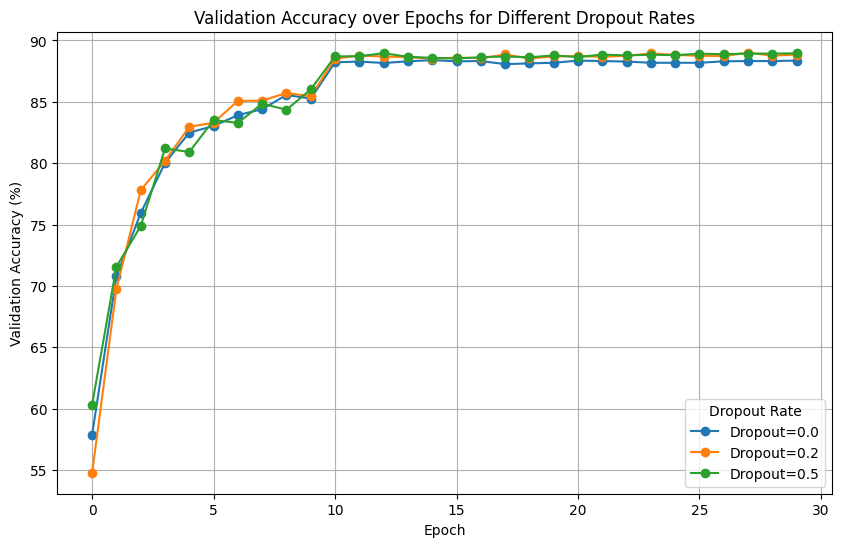

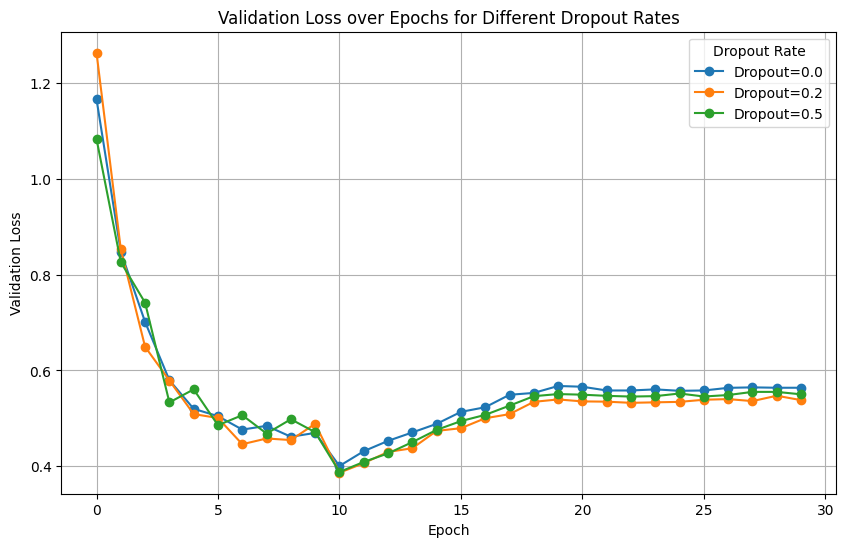

In [34]:
# Plot Validation Accuracy for each dropout rate in a single plot
plt.figure(figsize=(10, 6))
for rate, metrics in results.items():
    plt.plot(metrics["val_accuracies"], label=f"Dropout={rate}", marker='o')

# Plot settings
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy over Epochs for Different Dropout Rates")
plt.legend(title="Dropout Rate")
plt.grid(True)
plt.show()

# Plot Validation Loss for each dropout rate in a single plot
plt.figure(figsize=(10, 6))
for rate, metrics in results.items():
    plt.plot(metrics["val_losses"], label=f"Dropout={rate}", marker='o')

# Plot settings
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss over Epochs for Different Dropout Rates")
plt.legend(title="Dropout Rate")
plt.grid(True)
plt.show()

### Residual Connections

In [4]:
# Baseline performance with Adam optimizer and dropout rate = 0.2
baseline_accuracy = 88.57  # Final test accuracy for baseline model
baseline_train_accuracies = [
    41.43, 64.70, 74.81, 80.00, 83.33, 85.97, 88.24, 89.75, 91.28, 92.52, 
    96.97, 98.27, 98.71, 99.03, 99.28, 99.44, 99.51, 99.47, 99.47, 99.59, 
    99.65, 99.70, 99.65, 99.78, 99.80, 99.78, 99.80, 99.80, 99.81, 99.81
]
baseline_val_accuracies = [
    54.77, 69.74, 77.79, 80.20, 82.96, 83.30, 85.07, 85.10, 85.72, 85.44,
    88.52, 88.77, 88.69, 88.64, 88.64, 88.51, 88.54, 88.66, 88.66, 88.72,
    88.75, 88.67, 88.67, 88.76, 88.76, 88.76, 88.76, 88.80, 88.85, 88.85
]
baseline_train_losses = [
    1.5664, 0.9956, 0.7258, 0.5707, 0.4775, 0.4041, 0.3400, 0.2924, 0.2491, 0.2129,
    0.0918, 0.0554, 0.0411, 0.0315, 0.0251, 0.0208, 0.0171, 0.0172, 0.0138, 0.0152,
    0.0115, 0.0107, 0.0101, 0.0071, 0.0073, 0.0079, 0.0071, 0.0074, 0.0070, 0.0070
]
baseline_val_losses = [
    1.2633, 0.8531, 0.6493, 0.5789, 0.5088, 0.5006, 0.4459, 0.4578, 0.4546, 0.4886,
    0.3864, 0.4064, 0.4298, 0.4375, 0.4737, 0.4793, 0.5001, 0.5087, 0.5344, 0.5394,
    0.5333, 0.5347, 0.5323, 0.5359, 0.5471, 0.5380, 0.5380, 0.5380, 0.5380, 0.5380
]

# Store baseline metrics in results dictionary
results = {
    0.2: {  # Using dropout rate of 0.2 as baseline
        "test_accuracy": baseline_accuracy,
        "train_accuracies": baseline_train_accuracies,
        "val_accuracies": baseline_val_accuracies,
        "train_losses": baseline_train_losses,
        "val_losses": baseline_val_losses,
    }
}

In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the EfficientNet-B0 with residual connections model
class EfficientNetB0WithResidual(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(EfficientNetB0WithResidual, self).__init__()
        # Load the base EfficientNet-B0 model
        self.model = models.efficientnet_b0(pretrained=False)
        
        # Modify the classifier to include dropout and adjust for 10 classes (CIFAR-10)
        num_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 10)
        )
        
    def forward(self, x):
        # Pass through each block with potential residual connections
        for idx, layer in enumerate(self.model.features):
            residual = x  # Store the input for the residual connection
            x = layer(x)
            # Add residual connection if dimensions match
            if x.shape == residual.shape:
                x += residual  # Add the skip connection
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.model.classifier(x)
        return x

# Initialize the model and move it to the correct device
residual_model = EfficientNetB0WithResidual(dropout_rate=0.2).to(device)

# Define the optimizer and criterion
optimizer = Adam(residual_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training function without early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            # Move images and labels to the correct device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            running_train_loss += loss.item() * images.size(0)

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Accumulate validation loss
                running_val_loss += loss.item() * images.size(0)

                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
    
    # Save the model after training
    torch.save(model.state_dict(), f"{model_name}_final.pth")
    print(f"Model {model_name} saved!")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train and evaluate the residual model
train_losses_residual, val_losses_residual, train_accuracies_residual, val_accuracies_residual = train_model(
    residual_model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name="EfficientNet-B0_Residual"
)

# Define an evaluation function to calculate test accuracy
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Evaluate the model on the test se
residual_test_accuracy = evaluate_model(residual_model, test_loader)
print(f"Residual Model Test Accuracy: {residual_test_accuracy:.2f}%")


Epoch [1/30], Train Loss: 1.5581, Val Loss: 1.1888, Train Acc: 42.11%, Val Acc: 56.76%
Epoch [2/30], Train Loss: 0.9889, Val Loss: 0.8404, Train Acc: 64.77%, Val Acc: 70.31%
Epoch [3/30], Train Loss: 0.7173, Val Loss: 0.6525, Train Acc: 75.14%, Val Acc: 77.31%
Epoch [4/30], Train Loss: 0.5628, Val Loss: 0.5621, Train Acc: 80.48%, Val Acc: 81.26%
Epoch [5/30], Train Loss: 0.4639, Val Loss: 0.5218, Train Acc: 83.77%, Val Acc: 82.09%
Epoch [6/30], Train Loss: 0.3908, Val Loss: 0.5042, Train Acc: 86.46%, Val Acc: 83.01%
Epoch [7/30], Train Loss: 0.3352, Val Loss: 0.4618, Train Acc: 88.32%, Val Acc: 84.55%
Epoch [8/30], Train Loss: 0.2789, Val Loss: 0.4844, Train Acc: 90.17%, Val Acc: 84.54%
Epoch [9/30], Train Loss: 0.2430, Val Loss: 0.4725, Train Acc: 91.47%, Val Acc: 84.98%
Epoch [10/30], Train Loss: 0.2002, Val Loss: 0.4858, Train Acc: 92.89%, Val Acc: 85.45%
Epoch [11/30], Train Loss: 0.1789, Val Loss: 0.4529, Train Acc: 93.79%, Val Acc: 86.16%
Epoch [12/30], Train Loss: 0.1540, Val Lo

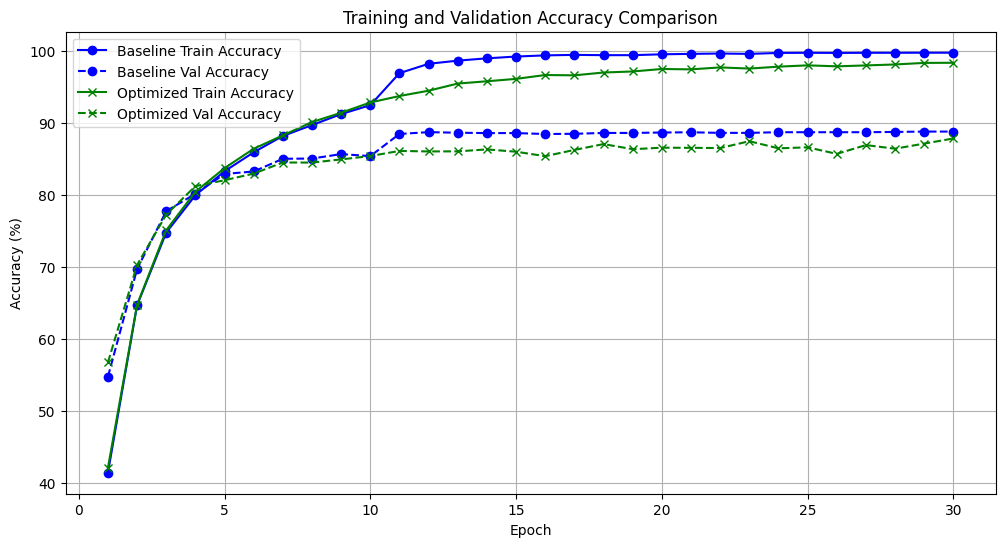

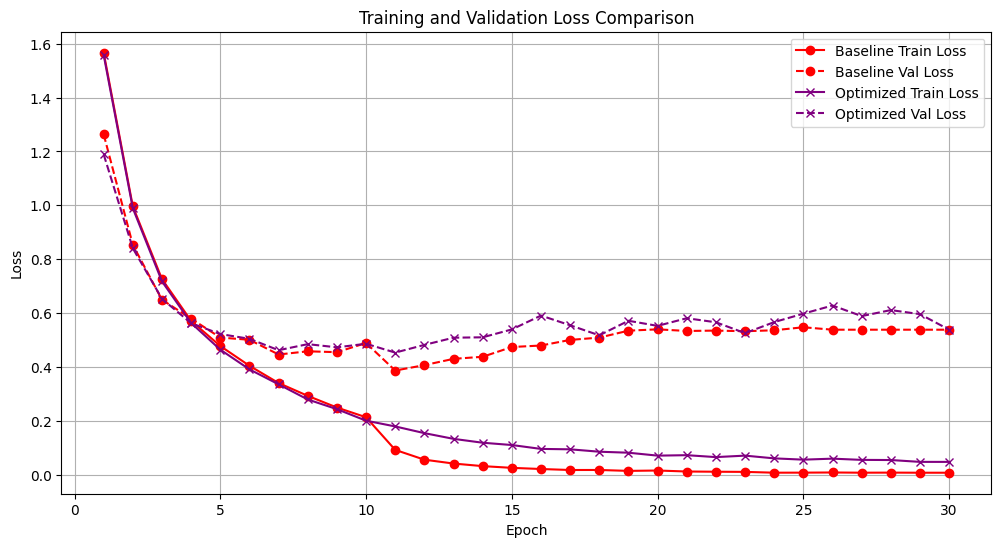

In [ ]:
# Baseline metrics (as provided)
baseline_accuracy = 88.57  # Final test accuracy for baseline model
baseline_train_accuracies = [
    41.43, 64.70, 74.81, 80.00, 83.33, 85.97, 88.24, 89.75, 91.28, 92.52, 
    96.97, 98.27, 98.71, 99.03, 99.28, 99.44, 99.51, 99.47, 99.47, 99.59, 
    99.65, 99.70, 99.65, 99.78, 99.80, 99.78, 99.80, 99.80, 99.81, 99.81
]
baseline_val_accuracies = [
    54.77, 69.74, 77.79, 80.20, 82.96, 83.30, 85.07, 85.10, 85.72, 85.44,
    88.52, 88.77, 88.69, 88.64, 88.64, 88.51, 88.54, 88.66, 88.66, 88.72,
    88.75, 88.67, 88.67, 88.76, 88.76, 88.76, 88.76, 88.80, 88.85, 88.85
]
baseline_train_losses = [
    1.5664, 0.9956, 0.7258, 0.5707, 0.4775, 0.4041, 0.3400, 0.2924, 0.2491, 0.2129,
    0.0918, 0.0554, 0.0411, 0.0315, 0.0251, 0.0208, 0.0171, 0.0172, 0.0138, 0.0152,
    0.0115, 0.0107, 0.0101, 0.0071, 0.0073, 0.0079, 0.0071, 0.0074, 0.0070, 0.0070
]
baseline_val_losses = [
    1.2633, 0.8531, 0.6493, 0.5789, 0.5088, 0.5006, 0.4459, 0.4578, 0.4546, 0.4886,
    0.3864, 0.4064, 0.4298, 0.4375, 0.4737, 0.4793, 0.5001, 0.5087, 0.5344, 0.5394,
    0.5333, 0.5347, 0.5323, 0.5359, 0.5471, 0.5380, 0.5380, 0.5380, 0.5380, 0.5380
]

# Optimized model metrics (replace these lists with your actual optimized data)
optimized_train_accuracies = train_accuracies_residual  # Replace with actual values
optimized_val_accuracies = val_accuracies_residual  # Replace with actual values
optimized_train_losses = train_losses_residual  # Replace with actual values
optimized_val_losses = val_losses_residual  # Replace with actual values

# Number of epochs
epochs = range(1,31)

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, baseline_train_accuracies, label="Baseline Train Accuracy", marker='o', color='blue')
plt.plot(epochs, baseline_val_accuracies, label="Baseline Val Accuracy", marker='o', linestyle='--', color='blue')
plt.plot(epochs, optimized_train_accuracies, label="Optimized Train Accuracy", marker='x', color='green')
plt.plot(epochs, optimized_val_accuracies, label="Optimized Val Accuracy", marker='x', linestyle='--', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, baseline_train_losses, label="Baseline Train Loss", marker='o', color='red')
plt.plot(epochs, baseline_val_losses, label="Baseline Val Loss", marker='o', linestyle='--', color='red')
plt.plot(epochs, optimized_train_losses, label="Optimized Train Loss", marker='x', color='purple')
plt.plot(epochs, optimized_val_losses, label="Optimized Val Loss", marker='x', linestyle='--', color='purple')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Initialize the results dictionary with the baseline data
results = {
    0.001: {
        "test_accuracy": baseline_accuracy,
        "train_accuracies": baseline_train_accuracies,
        "val_accuracies": baseline_val_accuracies,
        "train_losses": baseline_train_losses,
        "val_losses": baseline_val_losses,
    }
}

In [4]:


# Define the EfficientNet-B0 model with residual connections and dropout
class EfficientNetB0WithResidual(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(EfficientNetB0WithResidual, self).__init__()
        # Load the base EfficientNet-B0 model without pretrained weights
        self.model = models.efficientnet_b0(pretrained=False)
        
        # Modify the classifier to include dropout and adjust for 10 classes (CIFAR-10)
        num_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 10)
        )
        
    def forward(self, x):
        # Pass through each block with potential residual connections
        for idx, layer in enumerate(self.model.features):
            residual = x  # Store the input for the residual connection
            x = layer(x)
            # Add residual connection if dimensions match
            if x.shape == residual.shape:
                x += residual  # Add the skip connection
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.model.classifier(x)
        return x


In [10]:
from torch.optim import Adam
import copy

# Function to train and evaluate with a specified learning rate
def train_with_learning_rate(train_loader, val_loader, test_loader, learning_rate, dropout_rate=0.2, num_epochs=30):
    # Initialize the model with the specified dropout rate
    model = EfficientNetB0WithResidual(dropout_rate=dropout_rate).to(device)
    
    # Define optimizer with the specified learning rate
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Train the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name=f"EfficientNet_LR_{learning_rate}"
    )
    
    # Evaluate on the test set
    test_accuracy = evaluate_model(model, test_loader)
    
    # Store the results
    results[learning_rate] = {
        "test_accuracy": test_accuracy,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "train_losses": train_losses,
        "val_losses": val_losses,
    }
    print(f"Test Accuracy with Learning Rate {learning_rate}: {test_accuracy:.2f}%")

# Define additional learning rates to test
learning_rates = [0.01, 0.0001]

# Train and evaluate the model for each learning rate
for lr in learning_rates:
    print(f"\nTraining with Learning Rate: {lr} and Dropout: 0.2")
    train_with_learning_rate(train_loader, val_loader, test_loader, learning_rate=lr, dropout_rate=0.2, num_epochs=30)



Training with Learning Rate: 0.01 and Dropout: 0.2


/home/dwang/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dwang/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/30], Train Loss: 1.9041, Val Loss: 1.6518, Train Acc: 26.79%, Val Acc: 36.22%
Epoch [2/30], Train Loss: 1.4417, Val Loss: 1.3285, Train Acc: 45.56%, Val Acc: 51.69%
Epoch [3/30], Train Loss: 1.1343, Val Loss: 1.0564, Train Acc: 58.62%, Val Acc: 61.81%
Epoch [4/30], Train Loss: 0.9337, Val Loss: 0.8514, Train Acc: 66.34%, Val Acc: 70.38%
Epoch [5/30], Train Loss: 0.7833, Val Loss: 0.7533, Train Acc: 72.17%, Val Acc: 73.78%
Epoch [6/30], Train Loss: 0.6899, Val Loss: 0.6732, Train Acc: 75.84%, Val Acc: 76.61%
Epoch [7/30], Train Loss: 0.6110, Val Loss: 0.6354, Train Acc: 78.79%, Val Acc: 78.11%
Epoch [8/30], Train Loss: 0.5589, Val Loss: 0.7024, Train Acc: 80.68%, Val Acc: 76.62%
Epoch [9/30], Train Loss: 0.5048, Val Loss: 0.5968, Train Acc: 82.49%, Val Acc: 80.28%
Epoch [10/30], Train Loss: 0.4670, Val Loss: 0.5182, Train Acc: 83.69%, Val Acc: 82.50%
Epoch [11/30], Train Loss: 0.2899, Val Loss: 0.4289, Train Acc: 90.03%, Val Acc: 85.77%
Epoch [12/30], Train Loss: 0.2331, Val Lo

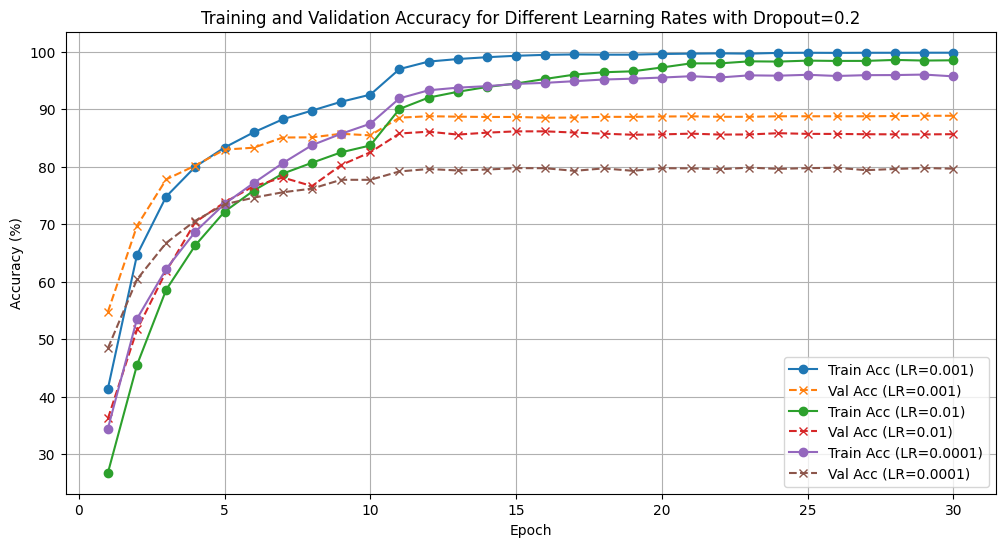

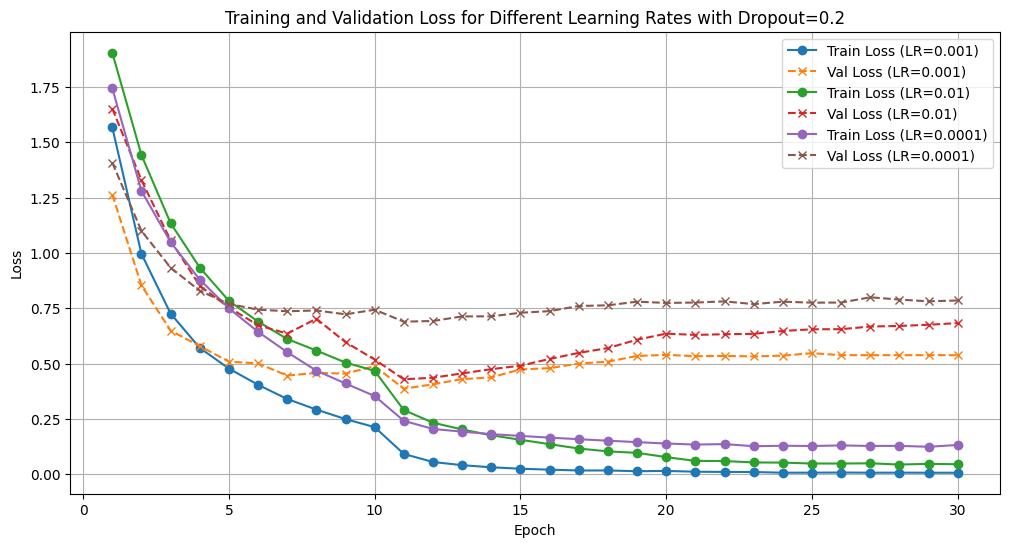

In [11]:
import matplotlib.pyplot as plt

# Number of epochs
epochs = range(1, 31)  # Assuming 30 epochs

# Plot Training and Validation Accuracy for Different Learning Rates
plt.figure(figsize=(12, 6))
for lr in [0.001] + learning_rates:
    plt.plot(epochs, results[lr]["train_accuracies"], label=f"Train Acc (LR={lr})", marker='o')
    plt.plot(epochs, results[lr]["val_accuracies"], label=f"Val Acc (LR={lr})", marker='x', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy for Different Learning Rates with Dropout=0.2")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss for Different Learning Rates
plt.figure(figsize=(12, 6))
for lr in [0.001] + learning_rates:
    plt.plot(epochs, results[lr]["train_losses"], label=f"Train Loss (LR={lr})", marker='o')
    plt.plot(epochs, results[lr]["val_losses"], label=f"Val Loss (LR={lr})", marker='x', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss for Different Learning Rates with Dropout=0.2")
plt.legend()
plt.grid(True)
plt.show()


### Data Augment ablation study

In [5]:
# Baseline metrics (as provided)
baseline_accuracy = 88.57  # Final test accuracy for baseline model
baseline_train_accuracies = [
    41.43, 64.70, 74.81, 80.00, 83.33, 85.97, 88.24, 89.75, 91.28, 92.52, 
    96.97, 98.27, 98.71, 99.03, 99.28, 99.44, 99.51, 99.47, 99.47, 99.59, 
    99.65, 99.70, 99.65, 99.78, 99.80, 99.78, 99.80, 99.80, 99.81, 99.81
]
baseline_val_accuracies = [
    54.77, 69.74, 77.79, 80.20, 82.96, 83.30, 85.07, 85.10, 85.72, 85.44,
    88.52, 88.77, 88.69, 88.64, 88.64, 88.51, 88.54, 88.66, 88.66, 88.72,
    88.75, 88.67, 88.67, 88.76, 88.76, 88.76, 88.76, 88.80, 88.85, 88.85
]
baseline_train_losses = [
    1.5664, 0.9956, 0.7258, 0.5707, 0.4775, 0.4041, 0.3400, 0.2924, 0.2491, 0.2129,
    0.0918, 0.0554, 0.0411, 0.0315, 0.0251, 0.0208, 0.0171, 0.0172, 0.0138, 0.0152,
    0.0115, 0.0107, 0.0101, 0.0071, 0.0073, 0.0079, 0.0071, 0.0074, 0.0070, 0.0070
]
baseline_val_losses = [
    1.2633, 0.8531, 0.6493, 0.5789, 0.5088, 0.5006, 0.4459, 0.4578, 0.4546, 0.4886,
    0.3864, 0.4064, 0.4298, 0.4375, 0.4737, 0.4793, 0.5001, 0.5087, 0.5344, 0.5394,
    0.5333, 0.5347, 0.5323, 0.5359, 0.5471, 0.5380, 0.5380, 0.5380, 0.5380, 0.5380
]

In [6]:
import random
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(12)
random.seed(12)
np.random.seed(12)

In [7]:
from torchvision import transforms

# Augmentation 1: Horizontal Flip
flip_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Augmentation 2: Horizontal Flip + Color Jitter
flip_jitter_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Dictionary to store each transform with a label
augmentation_strategies = {
    "flip": flip_transform,
    "flip_jitter": flip_jitter_transform
}


In [8]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets

# Load the CIFAR-10 dataset for the validation and test sets (no augmentation for these)
baseline_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define validation split ratio
validation_split = 0.2

# Load full training dataset (for train and validation split)
full_train_dataset = datasets.CIFAR10(root='./data', train=True, transform=baseline_transform, download=True)
train_size = int((1 - validation_split) * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Create train and validation datasets with a fixed split
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Load the test dataset
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=baseline_transform, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch
import random
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim import Adam  # Import Adam optimizer
import matplotlib.pyplot as plt
# Initialize results dictionary to store metrics
results = {}

def train_with_augmentation(transform, strategy_name, num_epochs=30):
    # Apply the augmentation transform to the training dataset
    train_dataset.dataset.transform = transform  # Apply transform only to the training part

    # Create data loaders for training, validation, and test
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize model
    model = EfficientNetB0WithResidual(dropout_rate=0.2).to(device)
    
    # Define optimizer and criterion
    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name=f"EfficientNet_{strategy_name}"
    )
    
    # Evaluate on the test set
    test_accuracy = evaluate_model(model, test_loader)
    
    # Store results
    results[strategy_name] = {
        "test_accuracy": test_accuracy,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "train_losses": train_losses,
        "val_losses": val_losses,
    }
    print(f"Test Accuracy with {strategy_name} augmentation: {test_accuracy:.2f}%")

# Run training for each augmentation strategy
for strategy_name, transform in augmentation_strategies.items():
    print(f"\nTraining with {strategy_name} augmentation")
    train_with_augmentation(transform, strategy_name, num_epochs=30)



Training with flip augmentation
Epoch [1/30], Train Loss: 1.5230, Val Loss: 1.2088, Train Acc: 43.55%, Val Acc: 56.88%
Epoch [2/30], Train Loss: 0.9689, Val Loss: 0.8377, Train Acc: 65.58%, Val Acc: 70.96%
Epoch [3/30], Train Loss: 0.7183, Val Loss: 0.6689, Train Acc: 75.25%, Val Acc: 76.87%
Epoch [4/30], Train Loss: 0.5785, Val Loss: 0.5330, Train Acc: 80.00%, Val Acc: 81.16%
Epoch [5/30], Train Loss: 0.4978, Val Loss: 0.4982, Train Acc: 82.85%, Val Acc: 82.45%
Epoch [6/30], Train Loss: 0.4365, Val Loss: 0.4816, Train Acc: 85.00%, Val Acc: 83.31%
Epoch [7/30], Train Loss: 0.3893, Val Loss: 0.4419, Train Acc: 86.63%, Val Acc: 85.04%
Epoch [8/30], Train Loss: 0.3450, Val Loss: 0.4165, Train Acc: 88.18%, Val Acc: 86.10%
Epoch [9/30], Train Loss: 0.3147, Val Loss: 0.3832, Train Acc: 89.03%, Val Acc: 87.02%
Epoch [10/30], Train Loss: 0.2783, Val Loss: 0.4110, Train Acc: 90.45%, Val Acc: 86.59%
Epoch [11/30], Train Loss: 0.1674, Val Loss: 0.2980, Train Acc: 94.29%, Val Acc: 90.29%
Epoch [1

In [ ]:
# Initialize results dictionary with baseline data
results = {
    "baseline": {
        "test_accuracy": baseline_accuracy,
        "train_accuracies": baseline_train_accuracies,
        "val_accuracies": baseline_val_accuracies,
        "train_losses": baseline_train_losses,
        "val_losses": baseline_val_losses,
    }
}


In [ ]:

# Number of epochs
epochs = range(1, 31)

# Plot Training and Validation Accuracy for Baseline and Augmentation Strategies
plt.figure(figsize=(12, 6))
for strategy in ["baseline"] + list(augmentation_strategies.keys()):
    plt.plot(epochs, results[strategy]["train_accuracies"], label=f"Train Acc ({strategy})", marker='o')
    plt.plot(epochs, results[strategy]["val_accuracies"], label=f"Val Acc ({strategy})", marker='x', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy for Baseline and Augmentation Strategies")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss for Baseline and Augmentation Strategies
plt.figure(figsize=(12, 6))
for strategy in ["baseline"] + list(augmentation_strategies.keys()):
    plt.plot(epochs, results[strategy]["train_losses"], label=f"Train Loss ({strategy})", marker='o')
    plt.plot(epochs, results[strategy]["val_losses"], label=f"Val Loss ({strategy})", marker='x', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss for Baseline and Augmentation Strategies")
plt.legend()
plt.grid(True)
plt.show()
